In [25]:
# Code for YPOD calibration Summer 2025 
# Hannigan Air Quality and Technology Research Lab
# ****************************************************************************
# @file     YPOD_calibration.ipynb
#
# @author 	Chiara Pesce, chpe5809@colorado.edu
# @date 	July 17 2025
# ****************************************************************************

# FOR MAC RUN ALL: Click out of script, cmd A, cmd return to run all cells (saves time when running entire script)
# FOR WINDOWS RUN ALL: IDK the shortcut, it may be under help >> shortcuts >> run all? (saves time when running entire script)

### FOLLOWING CODE CELL BLOCK(S): All script libraries

In [26]:
### importing libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import os
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from datetime import datetime, timedelta
from mlxtend.feature_selection import SequentialFeatureSelector

# Variables to change

In [27]:
# ****************************************************************************
# ****************************************************************************
### directories where pod data, reference data and figures are saved
os.chdir("/Users/Chiara/Documents/Documents - Chiara’s MacBook Air/Research/YPOD Calibration/Source Files") # directory for source files
save_dir = "/Users/Chiara/Documents/Documents - Chiara’s MacBook Air/Research/YPOD Calibration/Plots" # directory for write files
pod_id = ["Z2"] # pods to look at
# ["U4", "V1", "U8", "X0", "F2", "F4", "D4", "K3", "Z2", "Z3"]
# ["U7", "U6", "U2", "U1", "A1", "T4", "T2", "O1", "L1", "B8", "G2", "D8"] # pods to look at
### YPOD header names in order of csv file outputs
pod_headers = ["Timestamp", "Longitude", "Latitude", "PodID", "T_BME", "P_BME", "Temperature", "Relative Humidity", 
               "Fig2600", "Fig2602", "Ozone", "CO", "CO2", "PM1.0", "PM2.5", "PM10.0","Blank"] # headers for YPOD firmware
pod_col_drop = ["Blank", "Longitude", "Latitude", "T_BME"] # columns to drop in ypod data 
pollutants = ["CO2", "CO",  "PM2.5", "PM10.0", "Fig2600",
              "Fig2602", "Relative Humidity", "Temperature"] # pollutant plots to generate, needs to match header
utc_time_conversion = timedelta(hours = 7)
start_cutoff = pd.to_datetime("2025-07-09 10:00:00", format = "mixed") # start time for data window
end_cutoff = pd.to_datetime("2025-07-17 07:00:00", format = "mixed") # end time for data window
sample_time = "5min" # "h" for hourly, "d" for daily "xmin" for x minutes
ref1_filename = "EBAM.CSV" # reference file name
ref2_filename = "CO_CO2_Shed_Data.CSV" # reference file name
ref3_filename = "EBAM_PM.CSV" # reference file name
ref1_headers = ["Timestamp", "ConcRT", "ConcHR", "ConcS", "Flow", 
                "WS", "WD", "AT", "RH", "BP", "FT", "FRH", "Status"] # referance file headers
ref2_headers = ["Timestamp UTC", "Timestamp", "CO2_adu", "H2O_adu", "CO_adu", "CO2_ppm", "CO_ppm"] # referance file headers
ref3_headers = ["Timestamp (raw)", "Timestamp", "Conc25"] # referance file headers
ref1_row_drop = 4 # reference row to drop / ignore, include header rows
ref2_row_drop = 1 # reference row to drop / ignore, include header rows
ref3_row_drop = 4 # reference row to drop / ignore, include header rows
ref1_col_drop = ["Flow", "WS", "WD", "FT", "FRH", "Status", "ConcRT", "ConcHR","ConcS", "BP"] # reference columns to drop / ignore
ref2_col_drop = ["CO2_adu", "H2O_adu", "CO_adu", "Timestamp UTC"] # reference columns to drop / ignore
ref3_col_drop = ["Timestamp (raw)"] # reference columns to drop / ignore
ref1_data = ["AT", "RH"] # desired headers / data to look at and calibrate to
ref2_data = ["CO2_ppm", "CO_ppm"] # desired headers / data to look at and calibrate to
ref3_data = ["Conc25"] # desired headers / data to look at and calibrate to
### initializes arrays for each variable, needs to be in order, length of number of reference files
number_of_files = 3
filenames = [ref1_filename, ref2_filename, ref3_filename] # filename array
headers = [ref1_headers, ref2_headers, ref3_headers] # header array
row_drop = [ref1_row_drop, ref2_row_drop, ref3_row_drop] # row drop array
col_drop = [ref1_col_drop, ref2_col_drop, ref3_col_drop] # column drop array
data = [ref1_data, ref2_data, ref3_data] # data storage array
### variables to run models against (parameters to take into account), must match pod headers
temp_regr_var = ["Temperature"] # temperature model 
rh_regr_var = ["Relative Humidity"] # relative humidity model
co_regr_var = ["CO", "Relative Humidity"] # carbon monoxide model
co2_regr_var = ["CO2", "Relative Humidity", "Temperature"] # carbon dioxide model
pm25_regr_var = ["PM2.5", "Relative Humidity"]
# fig2600_reg_var = ["Fig2600", "Relative Humidity", "Temperature"]
# fig2502_reg_var = ["Fig2602", "Relative Humidity", "Temperature"]
models = ["Temperature", "Relative Humidity", "CO2", "CO", "PM2.5"] # parameters being calibrated
calibrated_units = ["(Degrees C)", "(%)", "(PPM)", "(PPM)", "(ug/m^3)"] # units for calibrated models, must be in order of "models" array
### stores regression variables in an array
regr_var = [temp_regr_var, rh_regr_var, co2_regr_var, co_regr_var, pm25_regr_var] # change when adding a model, must be in order of "models" array
ref_cal_var = ["AT", "RH", "CO2_ppm", "CO_ppm", "Conc25"] # reference variables used in calibration, must match ref instrument headers
### regression type toggles
linear_regression_mvlr = False # uses multivariable linear regression, least squares
ridge_mvlr = False # uses ridge linear regression, least squares with coefficient size penalties
lasso_mvlr = False # uses lasso linear regression, least squares with added regularization term, reduces features
gradient_boost_model = True # uses gradient boosting ML
random_forest_model = False # uses random forest ML
### plotting toggles
raw_pod_data_plotting = False # plots raw timeseries data from pods in pod_id array
model_accuracy_plotting = True # plots actual vs predicted model values for calibration variable (linear comparison)
model_timeseries_plotting = True # plots model timeseries data against referece timeseries data (timeseries comparison)
display_pod_data_timeseries = True # displays the pod timeseries data on the above plot
save_plots = True # saves plots to save_dir
# ****************************************************************************
# ****************************************************************************

### FOLLOWING CODE CELL BLOCK(S): Code for importing and formatting all reference data

In [28]:
### will store dataframe for each reference instrument
reference_file = None

### for loop to iterate through refernce files and import, format data
for index in range(number_of_files) :
    
    ### reading in reference file, adding headers to dataframe
    ref_data = pd.read_csv(filenames[index])
    ref_data.columns = headers[index]
    ref_data.head()
    ref_data.drop(ref_data.head(row_drop[index]).index, inplace = True) # gets rid of unneeded rows

    ### formatting timestamps to datetime, cropping dataframe to data window of interest
    ref_data["Timestamp"] = pd.to_datetime(ref_data["Timestamp"], format = "mixed")
    ref_data = ref_data[ref_data["Timestamp"] >= start_cutoff] # deletes all cells before start cutoff
    ref_data = ref_data[ref_data["Timestamp"] < end_cutoff] # deletes all cells after end cutoff
    ref_data = ref_data.drop(labels = col_drop[index], axis = 1) # deletes unused columns
    ### converts calibration data to numeric values for use in .resample
    
    for columns in data[index] :
        ref_data[columns] = pd.to_numeric(ref_data[columns], errors = "coerce") # converts to numeric values
        ref_data.loc[ref_data[columns] == 99999, columns] = np.nan  # replaces 99999 with NaN
        ref_data.loc[ref_data[columns] < 0, columns] = 0 # sets all negativer values to zero

    ref_data.set_index("Timestamp", inplace = True) # modifies dataframe directly
    ref_data = ref_data.resample(sample_time).mean().reset_index() # resamples / bins at the appropriate rate
    ref_data.fillna(ref_data.mean(numeric_only = True), inplace = True) # replaces NaN values with mean of adjacent points
    
    ### creates a single reference file with all rederence data needed
    if reference_file is None :
        reference_file = ref_data ### creates reference file
    else:
        reference_file = pd.merge(reference_file, ref_data, on = "Timestamp", how = "outer") # merges all the reference data

### FOLLOWING CODE CELL BLOCK(S): Code for importing data from YPOD's, generating initial sensor data visualization and exporting plots

In [29]:
### will store dataframe for each pod
all_pod_data = []

### initializing dicionaries for dynamic plots and axes (saves time when plotting, no hard coded pollutants)
figures = {} # entire figure (top-level container), everything that will share a figure space 
axes = {} # plot where pod data, any axis or format specifications are stored 

if raw_pod_data_plotting == True :  # if statement for plotting toggles  
    ### for loop to create separate figures and axis labels for pollutant plots
    for pollutant in pollutants :
        plt.style.use("dark_background") # dark mode!!
        with plt.style.context("dark_background") :
            fig, ax = plt.subplots() # .subplots creates a new figure space
            figures [pollutant] = fig # updates figure dictionary with pollutant
            axes [pollutant] = ax # updates axis dictionary with pollutant

### for loop to open and format each YPOD data set
for pod in pod_id :
    
    ### reading in files and creating headers
    POD_filename = f"YPOD{pod}_2025_07_09.CSV"
    pod_data = pd.read_csv(POD_filename)
    pod_data.columns = pod_headers
    pod_data.head() # "heads" dataframe
    pod_name = pod_data["PodID"] # stores pod ID for later

    ### formatting timestamps to datetime, cropping dataframe to data window of interest
    pod_data["Timestamp"] = pd.to_datetime(pod_data["Timestamp"], format = "mixed")
    pod_data = pod_data[pod_data["Timestamp"] >= start_cutoff] # deletes all cells before start cutoff
    pod_data = pod_data[pod_data["Timestamp"] <= end_cutoff] # deletes all cells after end cutoff
    pod_data.drop(labels = ["PodID"], axis = 1, inplace = True) # deletes string column

    # bins data to desired resolution
    ### .floor equates all values to the minimum in specified time period
    # data["Timestamp"] = data["Timestamp"].dt.floor("min") # "h" for hourly, "min" for minuetely 

    ### .resample interpolates data with specified bins
    pod_data.set_index("Timestamp", inplace = True) # modifies dataframe directly
    pod_data = pod_data.resample(sample_time).mean().reset_index() # resamples / bins at the appropriate rate

    ### adds back in pod ID to dataframe after resampling for debugging
    pod_data["PodID"] = pod_name
    pod_data.drop(labels = pod_col_drop, axis = 1, inplace = True) # deletes unused columns
    
    ### saving dataframe in an array for use later
    all_pod_data.append(pod_data)
    
    ### plotting each pollutant
    if raw_pod_data_plotting == True : # if statement for plotting toggles 
        for pollutant in pollutants :
            axes[pollutant].plot(pod_data["Timestamp"], pod_data[pollutant], label = f"POD {pod}", linewidth = 0.5)
            
if raw_pod_data_plotting == True :  # if statement for plotting toggles  
    ### plot formatting, modifies for each pollutant in the pollutants array
    for pollutant in pollutants :
        
        ### plotting specifications
        axes[pollutant].set_xlabel("Timestamp", fontweight = "bold") 
        axes[pollutant].set_ylabel(f"{pollutant} Signal (ADU)", fontweight = "bold")
        axes[pollutant].set_title(f"{pollutant} for Shed Pods", fontweight = "bold")
        axes[pollutant].legend()
        axes[pollutant].tick_params(axis = "x", labelsize = 7) # changes fontsize of x axis
        axes[pollutant].tick_params(axis = "y", labelsize = 7) # changes fontsize of y axis
        figures[pollutant].tight_layout()
        
        ### saving charts to directory for easy access
        if save_plots == True :
            name = f"{pollutant.replace(".", "_")}_shed_pods.png" # renames file to replace . with _ , png type
            path = os.path.join(save_dir, name) # uses path.join for compatibility across os, (good to prevent bugs)
            figures[pollutant].savefig(path, dpi = 300) # saves figure to specified path directory
            print(f"Saved: {path}") # for ui, prints confirmation of saved file

    plt.show()

### FOLLOWING CODE CELL BLOCK(S): Code for temperature MVLR / calibration fitting

Pod YPODZ2 Temperature model:

Feature Importances:
Temperature: 1.00000

R-squared: 0.99333
Mean absolute error: 0.4004176814545619
Mean squared error: 0.3159145613594625
Root mean squared error: 0.5620627735044036

Saved: /Users/Chiara/Documents/Documents - Chiara’s MacBook Air/Research/YPOD Calibration/Plots/YPODZ2_Temperature_model_accuracy.png


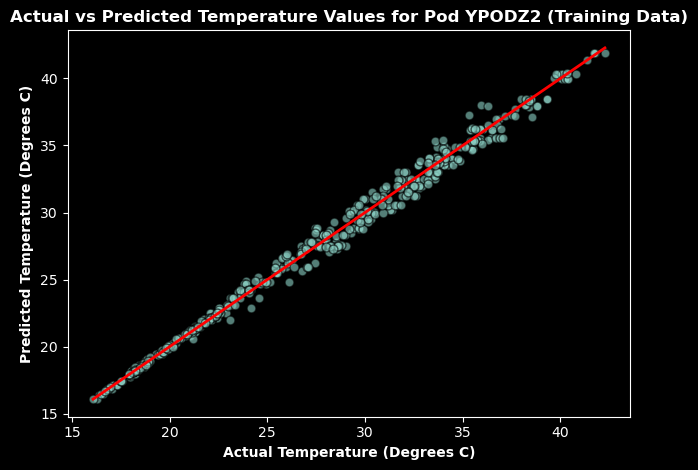

Saved: /Users/Chiara/Documents/Documents - Chiara’s MacBook Air/Research/YPOD Calibration/Plots/YPODZ2_Temperature_model_timeseries.png


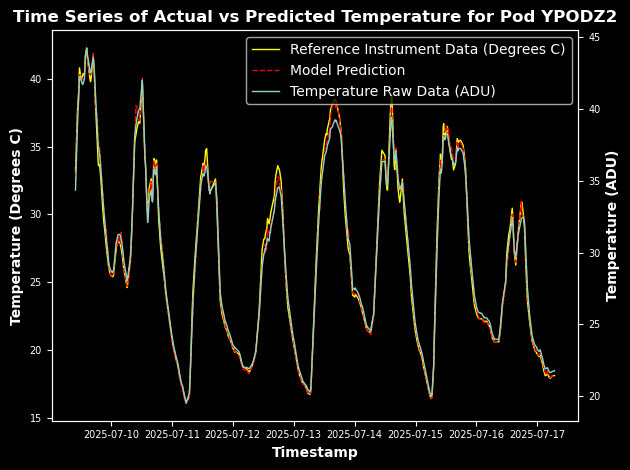

Pod YPODZ2 Relative Humidity model:

Feature Importances:
Relative Humidity: 1.00000

R-squared: 0.99465
Mean absolute error: 0.9370164110797092
Mean squared error: 1.5366876146916475
Root mean squared error: 1.239632048106069

Saved: /Users/Chiara/Documents/Documents - Chiara’s MacBook Air/Research/YPOD Calibration/Plots/YPODZ2_Relative_Humidity_model_accuracy.png


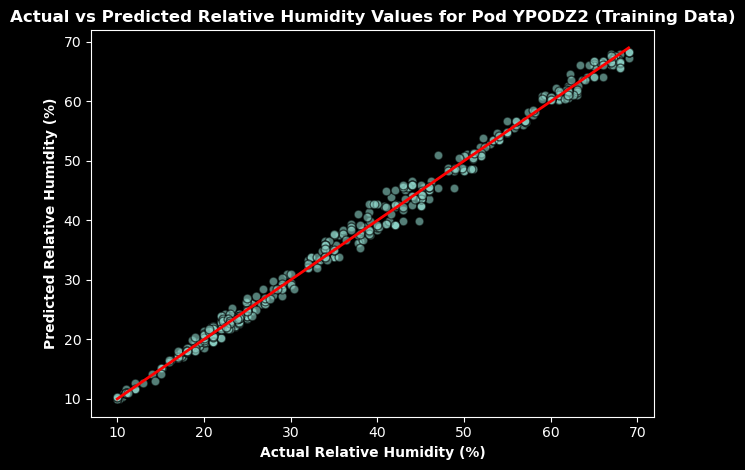

Saved: /Users/Chiara/Documents/Documents - Chiara’s MacBook Air/Research/YPOD Calibration/Plots/YPODZ2_Relative_Humidity_model_timeseries.png


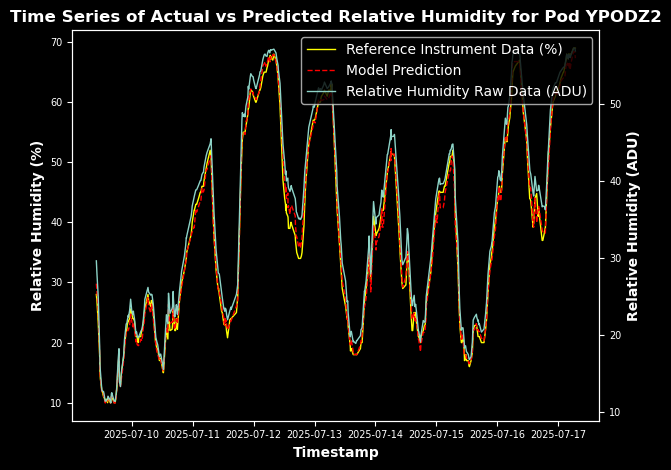

Pod YPODZ2 CO2 model:

Feature Importances:
CO2: 0.88100
Relative Humidity: 0.02777
Temperature: 0.09123

R-squared: 0.95959
Mean absolute error: 4.072843881977187
Mean squared error: 68.46628420145696
Root mean squared error: 8.274435582047694

Saved: /Users/Chiara/Documents/Documents - Chiara’s MacBook Air/Research/YPOD Calibration/Plots/YPODZ2_CO2_model_accuracy.png


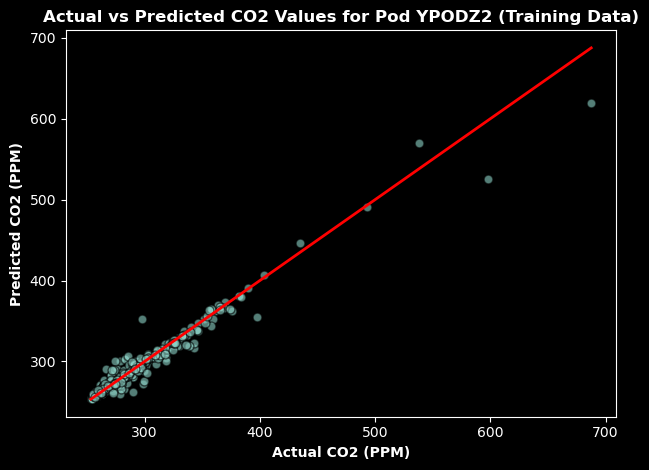

Saved: /Users/Chiara/Documents/Documents - Chiara’s MacBook Air/Research/YPOD Calibration/Plots/YPODZ2_CO2_model_timeseries.png


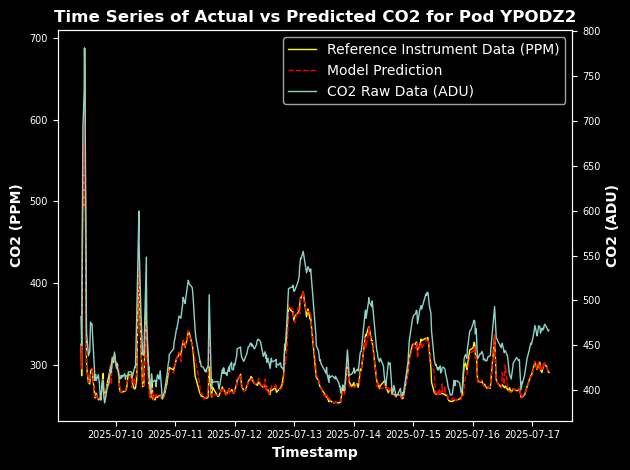

Pod YPODZ2 CO model:

Feature Importances:
CO: 0.86307
Relative Humidity: 0.13693

R-squared: 0.94721
Mean absolute error: 0.6000810840826698
Mean squared error: 2.396075617014234
Root mean squared error: 1.5479262311280322

Saved: /Users/Chiara/Documents/Documents - Chiara’s MacBook Air/Research/YPOD Calibration/Plots/YPODZ2_CO_model_accuracy.png


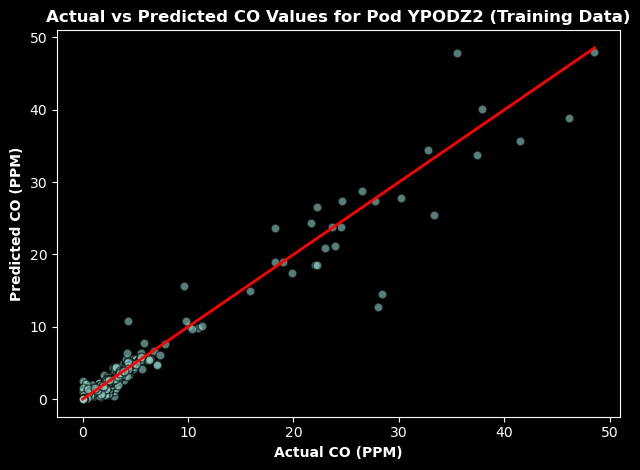

Saved: /Users/Chiara/Documents/Documents - Chiara’s MacBook Air/Research/YPOD Calibration/Plots/YPODZ2_CO_model_timeseries.png


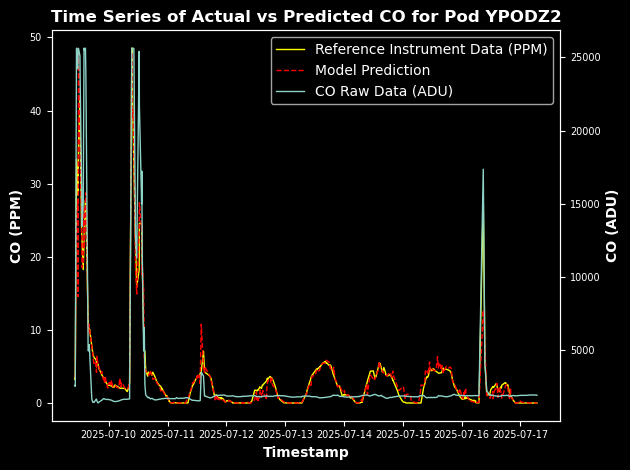

Pod YPODZ2 PM2.5 model:

Feature Importances:
PM2.5: 0.64419
Relative Humidity: 0.35581

R-squared: 0.51390
Mean absolute error: 29.10012199742175
Mean squared error: 27649.503865161383
Root mean squared error: 166.2813996367645

Saved: /Users/Chiara/Documents/Documents - Chiara’s MacBook Air/Research/YPOD Calibration/Plots/YPODZ2_PM2.5_model_accuracy.png


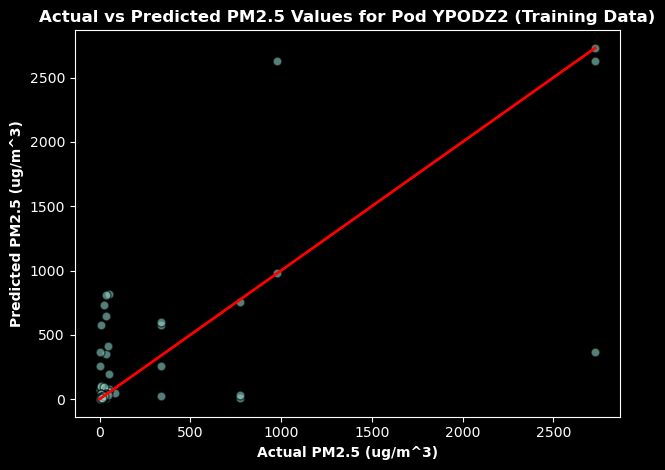

Saved: /Users/Chiara/Documents/Documents - Chiara’s MacBook Air/Research/YPOD Calibration/Plots/YPODZ2_PM2.5_model_timeseries.png


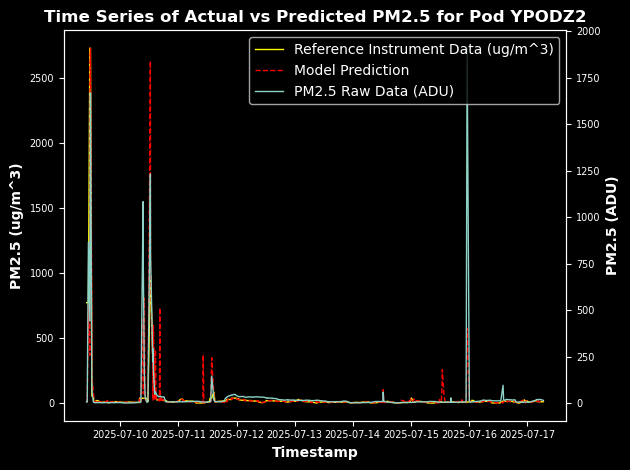

In [30]:
for model, ref_var, variables, units in zip(models, ref_cal_var, regr_var, calibrated_units) :

    ### for loop to run regression for each pod in dataset
    for pod in all_pod_data :

        pod_id_index = pod.iat[0, 12] # gets pod ID
        
        ### imputes all NaN values before running model
        pod_numeric = pod.select_dtypes(include = [np.number]) # this excludes any datetime values from the dataframe
        imp = SimpleImputer(missing_values = np.nan, strategy = "mean") # replaces all NaN values to mean of adjacent datapoints
        pod_imputed = pd.DataFrame(imp.fit_transform(pod_numeric), columns = pod_numeric.columns) # applies imputed values to pod_numeric
        
        ### assigning independent and dependent variables
        X = pod_imputed[variables] # pod variable(s) to fit
        y = reference_file[ref_var] # reference instrument data
    
        ### deals with pods that dont have the full data set
        if len(X) != len(y) : # if reference data size != pod data size
    
            ### adds timestamp back into dataframe for x and y 
            pod_imputed["Timestamp"] = pod["Timestamp"] # adds timestamp column back into pod_imputed dataframe
            pod_imputed.set_index("Timestamp") # sets timestamp as index
            pod_imputed = pod_imputed.reset_index() # resets index (housekeeping)
            reference_file.set_index("Timestamp") # sets timestamp as index
            # ref1_data = ref1_data.reset_index()
            X = pod_imputed[["Timestamp"] + variables] # redefines x to include timestamp
            y = reference_file[["Timestamp", ref_var]] # refefines y to include timestamp
            
            ### printing statements for ui
            common_times = X.index.intersection(y.index) # prints the number of matching indexes (timestamps)
            print(f"Pod {pod.iat[0, 12]} has an incomplete {model} data set")
            print(f"Common timestamps: {len(common_times)}")
            print(f"Reference data size: {len(y)}\n")
    
            ### makes a temporary concatenated dataframe and deletes all data where timestamps do not match
            concat = pd.merge(X, y, on = "Timestamp").dropna()
            X = concat[variables]
            y = concat[[ref_var]] # shortens data set to timestamps that match y values
    
        ### running lienar regression model
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10) # splits data into train and test
    
        ### creates linear regression model
        if linear_regression_mvlr == True : # regular linear regression
            regr = LinearRegression() 
        elif ridge_mvlr == True : # ridge linear model
            regr = Ridge(alpha = 1, random_state = 10)
        elif lasso_mvlr == True : # lasso linear model
            regr = Lasso(alpha = 1, random_state = 10)
        elif random_forest_model == True : # random forest ML
            regr = RandomForestRegressor(n_estimators = 100, random_state = 10)
        elif gradient_boost_model == True : # gradient boosting ML
            regr = XGBRegressor(objective = 'reg:squarederror', n_estimators = 100, random_state = 10)
        else : # for user interface
            print("No regression model chosen, please set a model = True in the 'variables to change' section.")
        
        regr.fit(X_train, y_train) # runs linear regression model
    
        ### generates predicted values for testing set
        y_predicted = regr.predict(X_test)
        y_predicted = np.clip(y_predicted, a_min = 0, a_max = None) # prevents negative prediction values
        r2 = r2_score(y_test, y_predicted) # computes rsquared values for prediction
    
        ### print statements for model
        print(f"Pod {pod_id_index} {model} model:")
        
        ### if statement to print coefficients for different models
        if hasattr(regr, "coef_") : # prints coefficents and intercept for linear models
            print("\nCoefficients:")
            for pred, coef in zip(variables, regr.coef_.flatten()): # for loop to print coeficients for each variable in model
                print(f"{pred}: {coef:.5f}")
            print(f"\nIntercept: {regr.intercept_.item():.5f}") # prints the intercept for the model
        elif hasattr(regr, "feature_importances_") : # prints feature importantce for ML models
            print("\nFeature Importances:")
            for pred, importance in zip(variables, regr.feature_importances_):
                print(f"{pred}: {importance:.5f}")
        else :  # for user interface
            print("\nModel does not provide linear coefficients (e.g., Random Forest).")

        ### print statements for error types, model accuracy
        print(f"\nR-squared: {r2:.5f}") # prints r2 for model
        print(f"Mean absolute error: {metrics.mean_absolute_error(y_test, y_predicted)}")
        print(f"Mean squared error: {metrics.mean_squared_error(y_test, y_predicted)}")
        print(f"Root mean squared error: {np.sqrt(metrics.mean_squared_error(y_test, y_predicted))}\n")
    
        ### makes sure testing y values are numeric for plotting
        if isinstance(y_test, pd.DataFrame): # checks if the y_testing data is a dataframe type
            y_test = y_test.iloc[:, 0] # selects the 0th column of testing data (whole data set)
            y_test = pd.to_numeric(y_test, errors = "coerce") # converts all values to numeric

        ### model accuracy plotting
        if model_accuracy_plotting == True :
            plt.scatter(y_test, y_predicted, alpha = 0.6, s = 40, edgecolors = "black", linewidth = 1) # scatter plot for model accuracy
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = "red", linewidth = 2) # y = x line
            min_val = min(y_test.min(), y_predicted.min()) # calculates the min of data set
            max_val = max(y_test.max(), y_predicted.max()) # calculates the max of data set
            pad = (max_val - min_val) * 0.05 # adds padding to the ends of the axes
            plt.xlim(min_val - pad, max_val + pad) # sets x limit
            plt.ylim(min_val - pad, max_val + pad) # sets y limit
            # plt.gca().set_aspect("equal", adjustable = "box") # makes the plot a square
            plt.xlabel(f"Actual {model} {units}", fontweight = "bold") # x axis label
            plt.ylabel(f"Predicted {model} {units}", fontweight = "bold") # y axis label
            plt.title(f"Actual vs Predicted {model} Values for Pod {pod_id_index} (Training Data)", fontweight = "bold") # plot title
            plt.tight_layout()
            
            ### saving charts to directory for easy access
            if save_plots == True :
                name = f"{pod_id_index}_{model.replace(" ", "_")}_model_accuracy.png" # names file
                path = os.path.join(save_dir, name) # uses path.join for compatibility across os, (good to prevent bugs)
                plt.savefig(path, dpi = 300) # saves figure to specified path directory
                print(f"Saved: {path}") # for ui, prints confirmation of saved file
                
            plt.show() # displays plot

        ### time series plotting
        if model_timeseries_plotting == True:
            fig, ax1 = plt.subplots() # sub axes for dual axis plot
            X_test["Timestamp"] = pod["Timestamp"].iloc[X_test.index] # aligns with original timestamps
            X_test["Model Prediction"] = y_predicted.flatten() # reshapes data into an array, adds to "predicted" in dataframe
            X_test["Reference Instrument Data"] = y_test.values.flatten() # reshapes data into an array, adds to "acrual" in dataframe, takes values
            X_test = X_test.sort_values("Timestamp") # sort by timestamp, not guaranteed after train_test_split
            ax1.plot(X_test["Timestamp"], X_test["Reference Instrument Data"], 
                     label = f"Reference Instrument Data {units}", color = "yellow", linewidth = 1) # plot for actual data
            ax1.plot(X_test["Timestamp"], X_test["Model Prediction"], label = "Model Prediction",
                     color = "red", linestyle = "--", linewidth = 1) # plot for predicted data
            ax1.set_xlabel("Timestamp", fontweight = "bold") # x axis label
            ax1.set_ylabel(f"{model} {units}", fontweight = "bold") # y axis label
            ax1.tick_params(axis = "x", labelsize = 7) # changes fontsize of x axis
            ax1.tick_params(axis = "y", labelsize = 7) # changes fontsize of y axis
            h1, l1 = ax1.get_legend_handles_labels() # stores first ax legend labels and handles
            if display_pod_data_timeseries == True : # if statement to display pod data on graph
                ax2 = ax1.twinx() # creates another axis for dual axis plot
                ax2.plot(X_test["Timestamp"], X_test[model], label = f"{model} Raw Data (ADU)", linewidth = 1) # plot for raw data
                ax2.set_ylabel(f"{model} (ADU)", fontweight = "bold")
                ax2.tick_params(axis = "y", labelsize = 7) # changes fontsize of y axis
                h2, l2 = ax2.get_legend_handles_labels() # stores second ax legend labels and handles
                handles = h1 + h2 # creates a handles type
                labels = l1 + l2 # creates a labels type
            else :
                handles = h1 # creates a handles type
                labels = l1 # creates a labels type
            plt.legend(handles, labels, loc = 'upper right') # creates a combined legend
            plt.title(f"Time Series of Actual vs Predicted {model} for Pod {pod_id_index}", fontweight = "bold") # plot title
            plt.tight_layout()
            
            ### saving charts to directory for easy access
            if save_plots == True :
                name = f"{pod_id_index}_{model.replace(" ", "_")}_model_timeseries.png" # names file
                path = os.path.join(save_dir, name) # uses path.join for compatibility across os, (good to prevent bugs)
                plt.savefig(path, dpi = 300) # saves figure to specified path directory
                print(f"Saved: {path}") # for ui, prints confirmation of saved file

            plt.show() # displays plot